# Plot data from Rigol DS1054Z scope

## Import the libraries

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 8]
plt.rcParams['figure.dpi'] = 300
import numpy as np
import math
import pandas as pd
import csv
from datetime import datetime 
import glob
from scipy.signal import savgol_filter

## Import local libraries

In [2]:
from appvib import ClassPlotSupport, ClSignalFeaturesEst, ClSigFeatures, ClSigCompUneven

## Define plot mode. 
Interactive mode is helpful for visuallizing the program execution

In [3]:
#%matplotlib widget

## Define function to read header values

In [4]:
def get_header(str_filename_in):
    """
    
    Pulls in the header information from the scope files
    
    Parameters
    ----------
    str_filename_in : string
        full file name to read
        
    Returns
    -------
    list : header values
    
    """
    
    # Read the CSV headers
    print(str_filename_in)
    file_handle = open(str_filename_in)
    csv_reader = csv.reader(file_handle)
    lst_header = next(csv_reader)
    print(lst_header)
    file_handle.close()

    return lst_header

## Define files to read

A helpful discussion on getting .csv files into Panda:
https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

Choose files by entering them in a list. Clumsy, but I need to test specific cases

In [5]:
lst_filenames = ['test_001_000.csv', 'test_001_001.csv', 'test_001_002.csv', 'test_001_003.csv', 'test_001_004.csv']

Or all files with a given extension in the current director

In [6]:
#lst_filenames = []
#for file in glob.glob("*.csv"):
#    lst_filenames.append(file)

## Read in the first data set and visualize the results

In [7]:
help(ClSigFeatures.b_read_data_as_df)

Help on function b_read_data_as_df in module appvib:

b_read_data_as_df(self, str_filename=None)
    Read the entire file in as a pandas dataframe
    
    Parameters
    ----------
    str_filename : string
        Filename, including .csv extension,  to read. If None then filename stored
        in the class is used
    
    Returns
    --------
    lst_data : list
            pandas dataframe : dataframe with all data from the file
            numpy array, datetime : vector with date and timestamps
            numpy array, double : vector with signal sampling rates
            numpy array, double : vector with delta time interval for each signal
            list, string :  list with engineering units descriptions
            list, string : machine name



### Plot a data collection

Setup the storage arrays

In [8]:
dt_timestamp_base = datetime.now()
np_d_time_ch1 = np.array([])
np_d_time_ch2 = np.array([])
np_d_eventtimes_ch1 = np.array([])
np_d_eventtimes_ch2 = np.array([])
np_d_rpm_ch1 = np.array([])
np_d_nx_ch1 = np.array([])
np_d_nx_ch2 = np.array([])
np_d_pp_ch1 = np.array([])
np_d_pp_ch2 = np.array([])
np_d_rms_ch1 = np.array([])
np_d_rms_ch2 = np.array([])
np_dt_timestamp_ch1 = np.array([])
np_dt_timestamp_ch2 = np.array([])

Loop through the files

In [9]:
for idx, str_filename in enumerate(lst_filenames):
    class_file = ClSigFeatures([1.,2.,3.], 1.)
    lst_file = class_file.b_read_data_as_df(str_filename)

    df1 = lst_file[0]
    np_dt_timestamp_ch1 = np.append(np_dt_timestamp_ch1, lst_file[1][0])
    np_dt_timestamp_ch2 = np.append(np_dt_timestamp_ch2, lst_file[1][1])
    d_seconds_ch1 = (np_dt_timestamp_ch1[idx] - np_dt_timestamp_ch1[0]).total_seconds()
    d_seconds_ch2 = (np_dt_timestamp_ch2[idx] - np_dt_timestamp_ch2[0]).total_seconds()
    np_d_fs = lst_file[2]
    lst_str_eu = lst_file[4]
    lst_str_machine_name = lst_file[5]
    
    # Validate input
    assert( len(df1.CH1) == 1200) , 'Failed to load the correct number of samples'

    # Instantiate a new class and populate it with the file contents
    class1 = ClSigFeatures(df1.CH1, np_d_fs[0], dt_timestamp=np_dt_timestamp_ch1[idx], str_machine_name=lst_str_machine_name[1])
    
    # Add the second signal and plot it
    class1.idx_add_sig(df1.CH2, d_fs=np_d_fs[1], str_point_name='CH2', dt_timestamp=np_dt_timestamp_ch2[idx], 
                       str_machine_name=lst_str_machine_name[2])    
    class1.ylim_tb(ylim_tb_in=[-1.0, 1.0], idx=1)
    
    np_d_eventtimes = class1.np_d_est_triggers(np_d_sig=class1.np_d_sig, i_direction=0, d_threshold=0.125)
    
    # 1X extraction
    np_d_nx_ch1 = np.append(np_d_nx_ch1, class1.calc_nx(np_d_sig=class1.get_np_d_sig(idx=0), np_d_eventtimes=class1.np_d_eventtimes(),
                                          b_verbose=False))
    np_d_nx_ch2 = np.append(np_d_nx_ch2, class1.calc_nx(np_d_sig=class1.get_np_d_sig(idx=1), np_d_eventtimes=class1.np_d_eventtimes(),
                                          b_verbose=False))
    
    # Peak-to-peak estimation
    np_d_pp_ch1 = np.append(np_d_pp_ch1, 
                            savgol_filter(ClSignalFeaturesEst.np_d_est_amplitude(class1.get_np_d_sig(idx=0)), 101, 1))
    np_d_pp_ch2 = np.append(np_d_pp_ch2, 
                            savgol_filter(ClSignalFeaturesEst.np_d_est_amplitude(class1.get_np_d_sig(idx=1)), 101, 1))
    
    # RMS estimation
    np_d_rms_ch1 = np.append(np_d_rms_ch1, ClSignalFeaturesEst.np_d_est_rms(class1.get_np_d_sig(idx=0)))
    np_d_rms_ch2 = np.append(np_d_rms_ch2, ClSignalFeaturesEst.np_d_est_rms(class1.get_np_d_sig(idx=1)))
    
    # Time series. Eventtimes and signal times have to be tracked seperately
    np_d_time_ch1 =  np.append(np_d_time_ch1, class1.d_time_plot(idx=0)+d_seconds_ch1)
    np_d_time_ch2 =  np.append(np_d_time_ch2, class1.d_time_plot(idx=1)+d_seconds_ch2)
    np_d_eventtimes_ch1 = np.append(np_d_eventtimes_ch1, class1.np_d_eventtimes()+d_seconds_ch1)
    np_d_eventtimes_ch2 = np.append(np_d_eventtimes_ch2, class1.np_d_eventtimes(idx=1)+d_seconds_ch2)
    
    # RPM values
    np_d_rpm_ch1 = np.append(np_d_rpm_ch1, class1.np_d_rpm())

### Plot amplitude and phase over time (APHT plot)

#### Starting with Channel 1

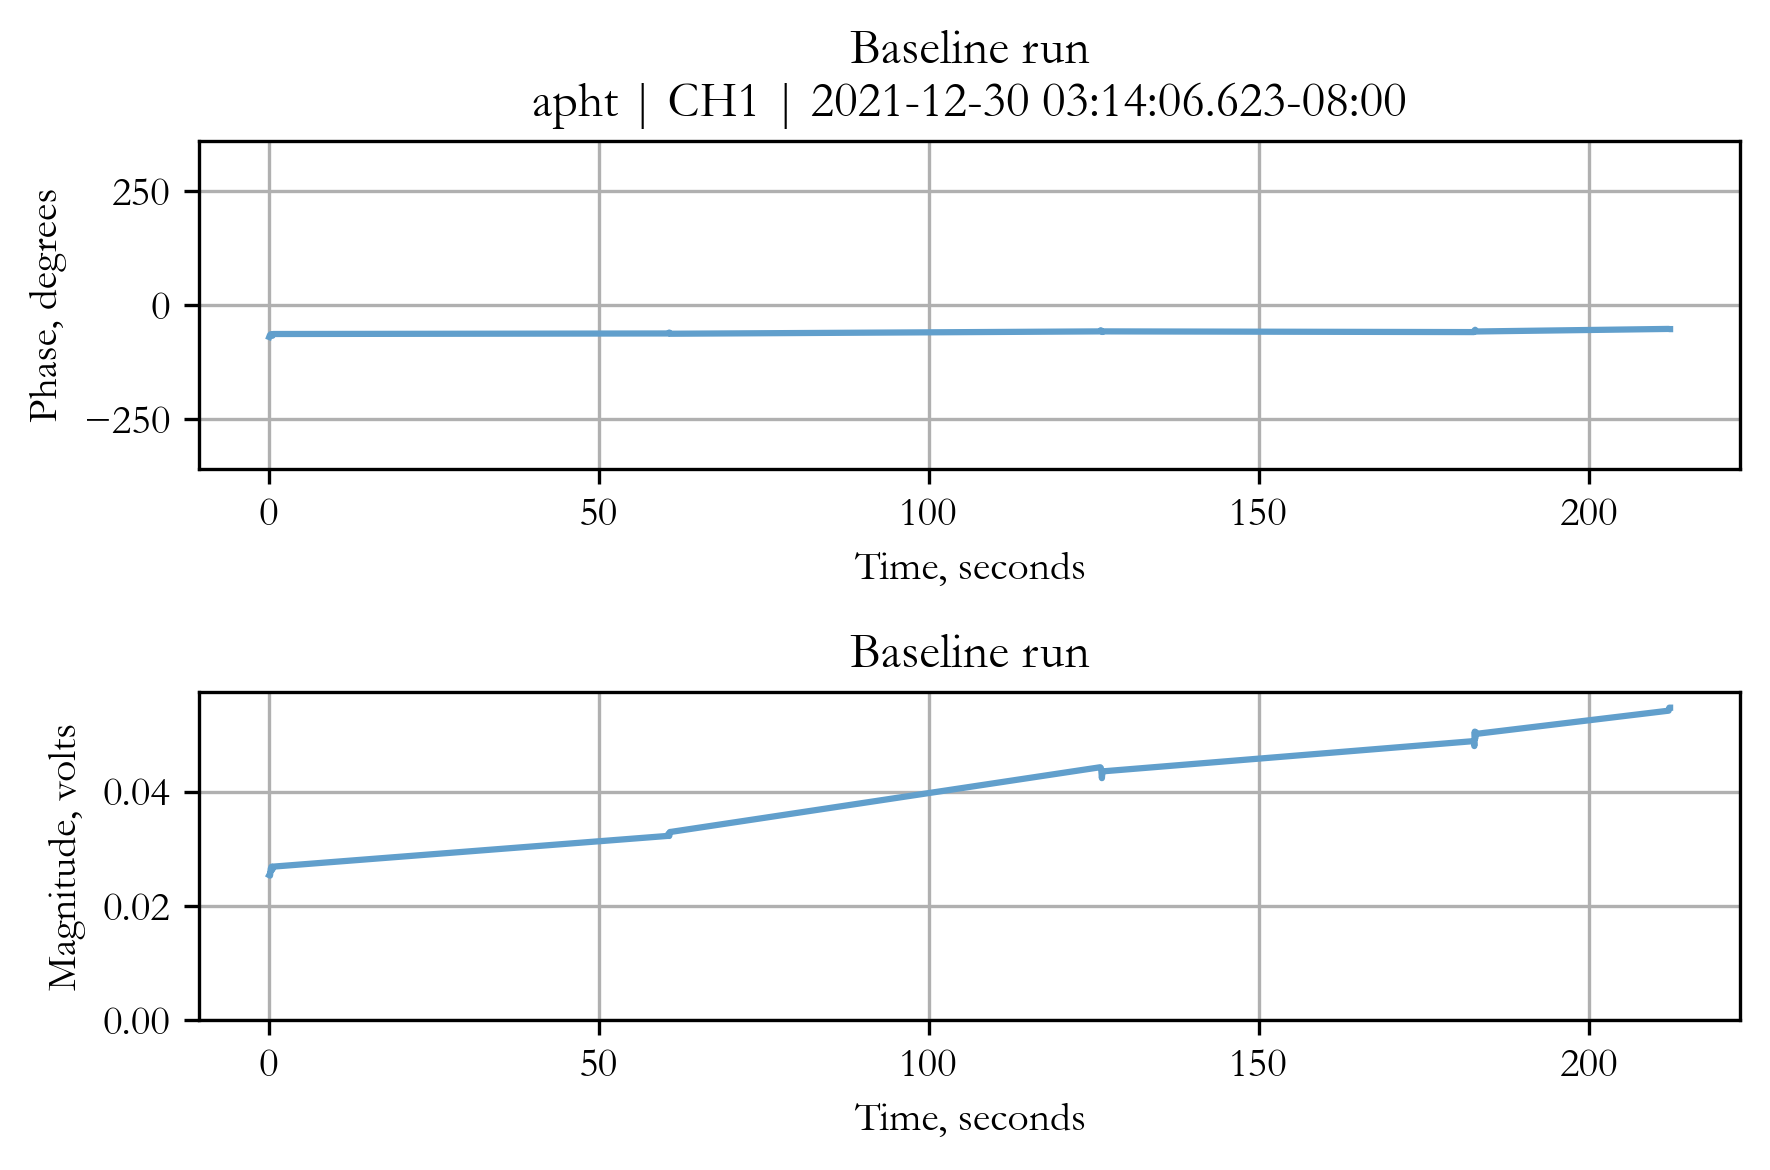

In [10]:
plt.rcParams['figure.figsize'] = [6, 4]
class_nx_ch1 = ClSigCompUneven(np_d_nx_ch1, np_d_eventtimes_ch1, str_eu='volts', str_point_name='CH1', dt_timestamp=dt_timestamp_base)
class_nx_ch1.str_plot_desc = 'Baseline run'
lst_apht_ch1 = class_nx_ch1.plt_apht()

#### Now for channel 2

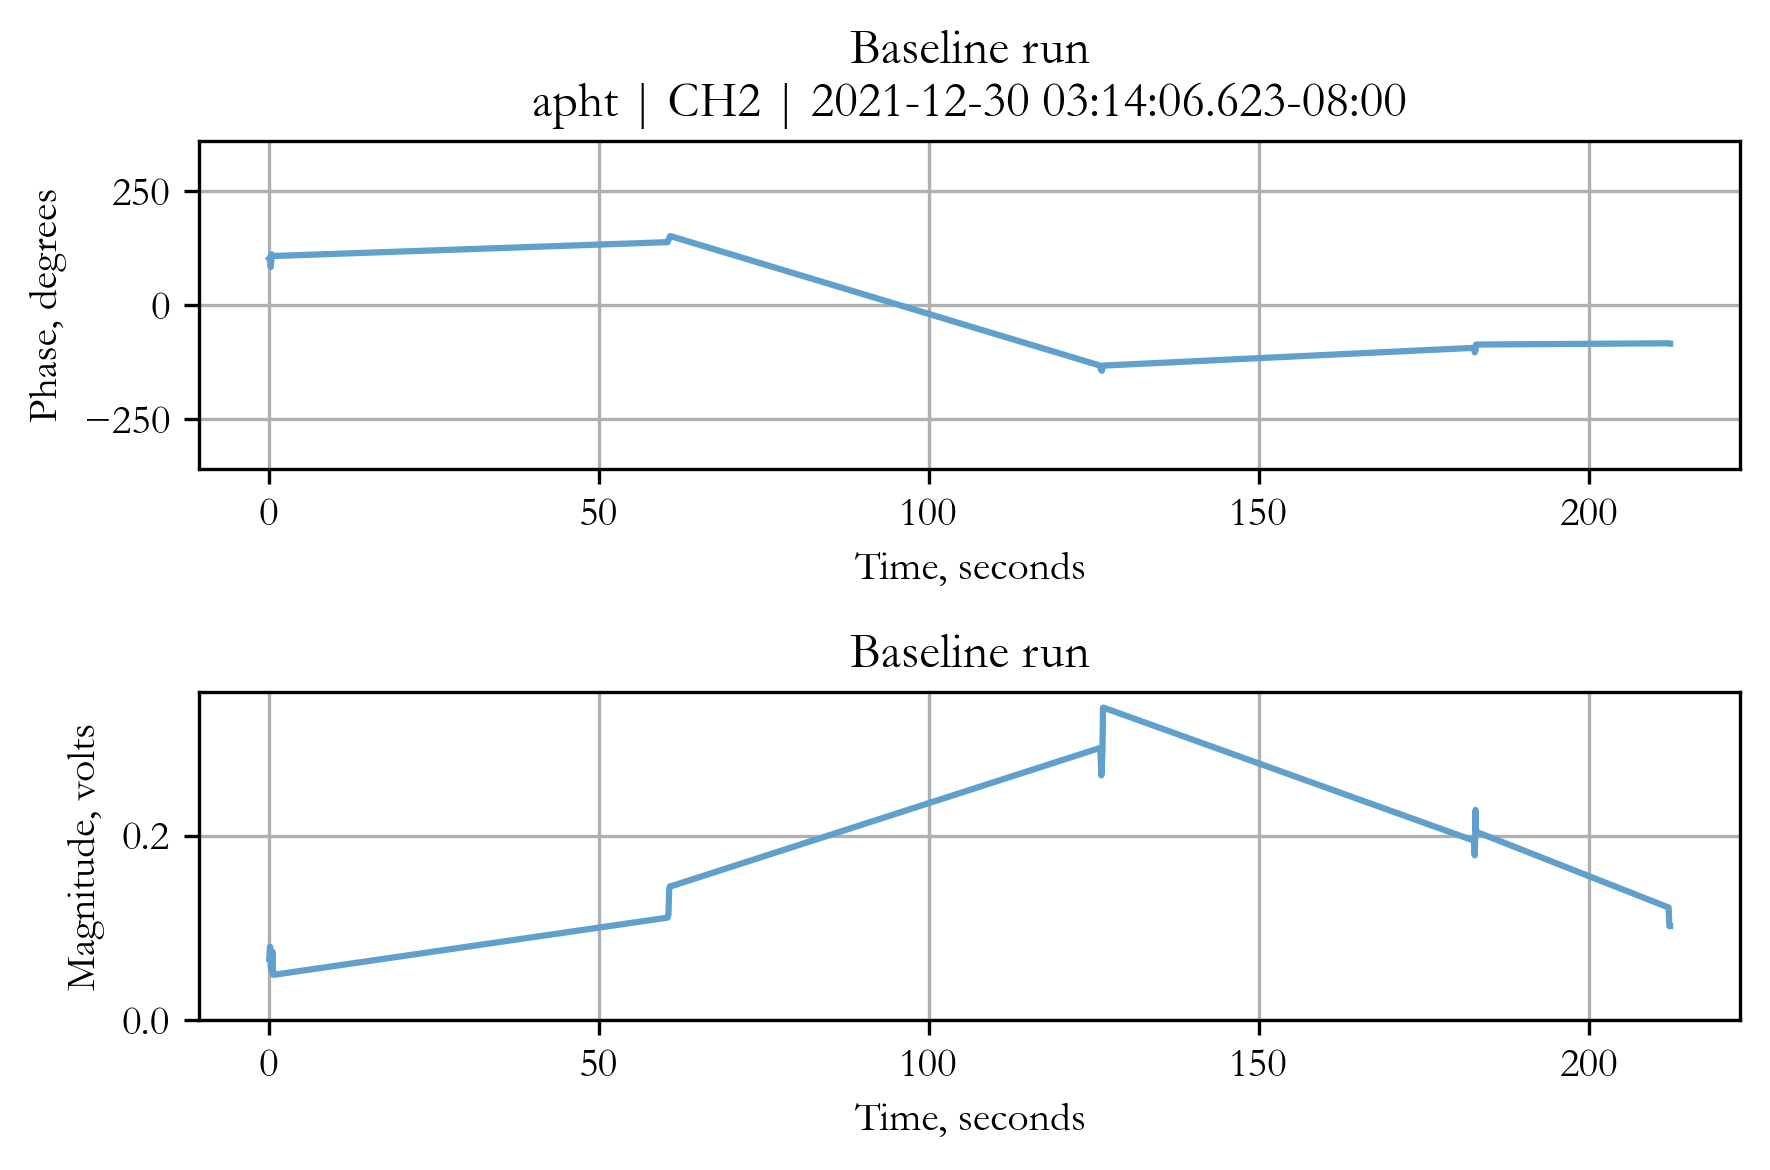

In [11]:
class_nx_ch2 = ClSigCompUneven(np_d_nx_ch2, np_d_eventtimes_ch1, str_eu='volts', str_point_name='CH2', 
                               dt_timestamp=dt_timestamp_base)
class_nx_ch2.str_plot_desc = 'Baseline run'
lst_apht_ch2 = class_nx_ch2.plt_apht()

### Plot 1X vectors in polar format

#### Channel 1 (Trigger)

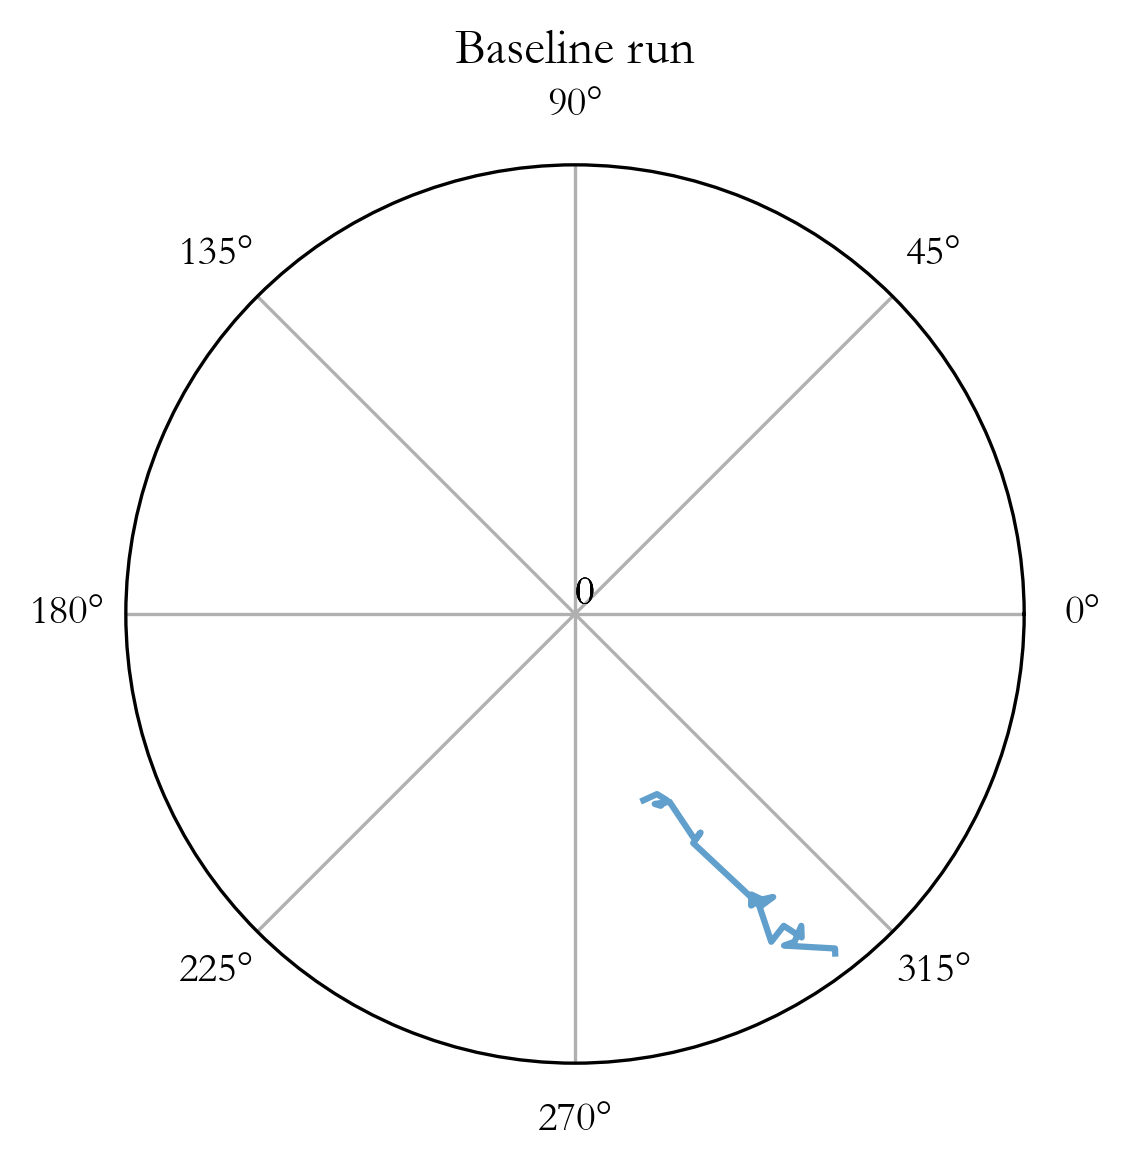

In [12]:
lst_polar_ch1 = class_nx_ch1.plt_polar()

#### Channel 2

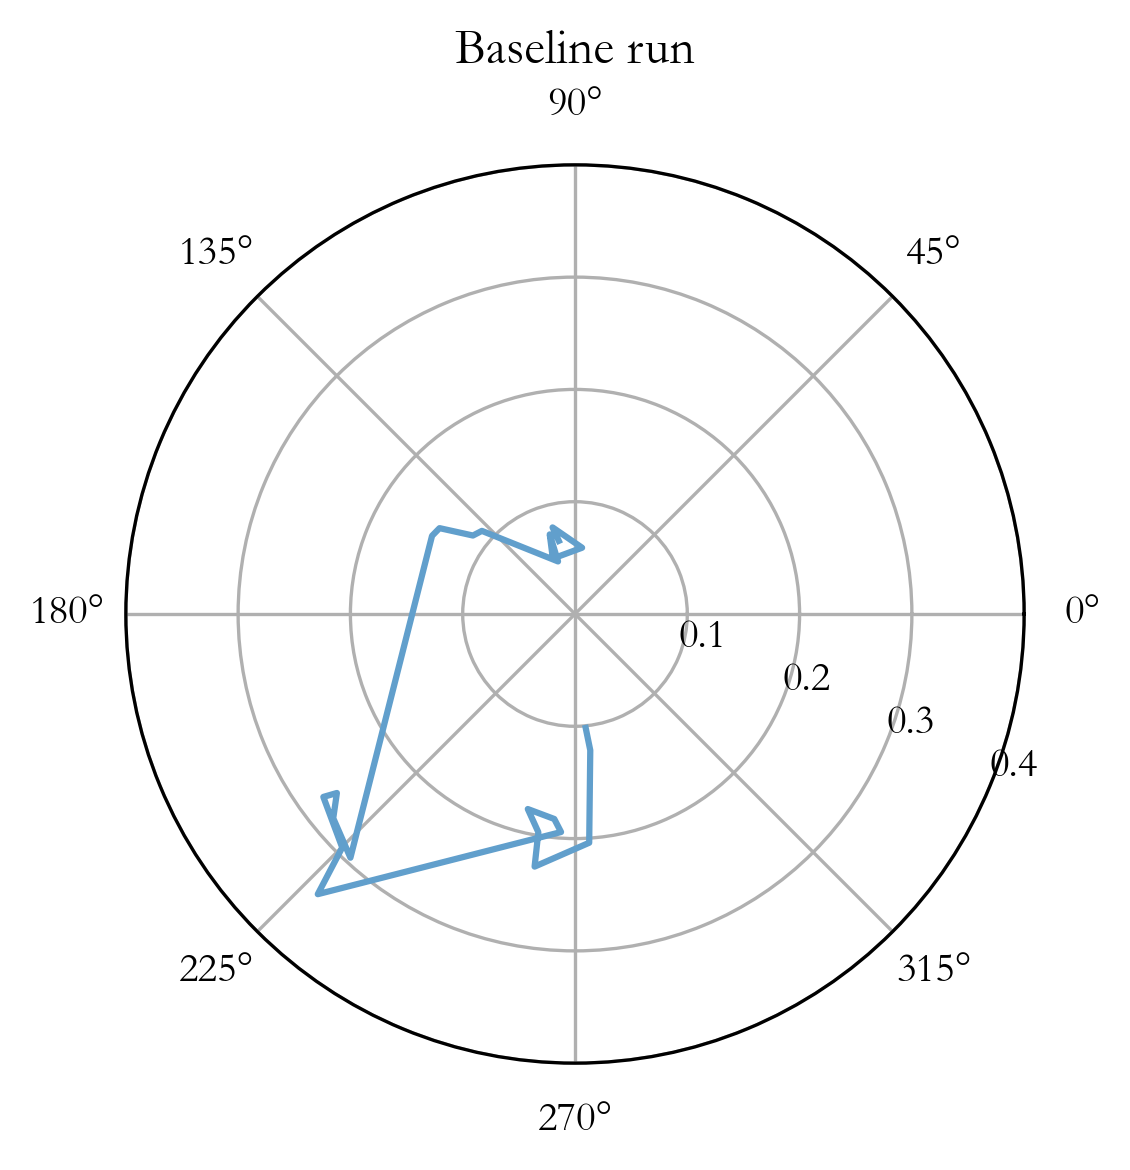

In [13]:
lst_polar_ch2 = class_nx_ch2.plt_polar()

### Timebase with complete sparklines

For this example, the first sparkline will display the absolute value of the 1X signal. We also need to calculate the crest factor from the pkpk and rms trends

In [14]:
np_d_1X_amp_ch2 = np.abs(np_d_nx_ch2)
np_d_crest_ch2 = ( np_d_pp_ch2 / 2.0 ) / np_d_rms_ch2 

Pull in the middle waveform from the csv file

In [15]:
class_file = ClSigFeatures([1.,2.,3.], 1.)
lst_file = class_file.b_read_data_as_df(lst_filenames[1])

Retrieve signal features

In [16]:
df1 = lst_file[0]
np_dt_timestamp_sig_ch1 = lst_file[1][0]
np_dt_timestamp_sig_ch2 = lst_file[1][1]
np_d_fs = lst_file[2]
lst_str_eu = lst_file[4]
lst_str_machine_name = lst_file[5]

Instantiate the class for the signal of interest

In [17]:
class_complete = ClSigFeatures(df1.CH2, np_d_fs[0], dt_timestamp=np_dt_timestamp_sig_ch2, 
                               str_machine_name=lst_str_machine_name[0])

Setup the custom sparklines to override the signal-specific defaults. Start by finding the closest index to the datetime mark of interest

In [18]:
idx_mark_eventtimes = ClassPlotSupport.get_idx_by_dt(np_d_eventtimes_ch1, np_dt_timestamp_ch1[0],
                                                         np_dt_timestamp_sig_ch2)
d_1X_pp = 2.0 * np_d_1X_amp_ch2[idx_mark_eventtimes]
d_rpm = np_d_rpm_ch1[idx_mark_eventtimes]

In [19]:
idx_mark = ClassPlotSupport.get_idx_by_dt(np_d_time_ch1, np_dt_timestamp_ch1[0],
                                                         np_dt_timestamp_sig_ch2)
d_pp = np_d_pp_ch2[idx_mark]
d_rms = np_d_rms_ch2[idx_mark]
d_crest = np_d_crest_ch2[idx_mark]

Format and configure the description for the sparkline. Start with identifying the index for the eventtimes, then for discrete-time series data

In [20]:
lst_fmt_1X_pp = ClassPlotSupport.get_plot_round(d_1X_pp)
lst_fmt_pp = ClassPlotSupport.get_plot_round(d_pp)
lst_fmt_rms = ClassPlotSupport.get_plot_round(d_rms)
lst_fmt_crest = ClassPlotSupport.get_plot_round(d_crest)
lst_fmt_rpm = ClassPlotSupport.get_plot_round(d_rpm)

In [21]:
str_point_spark_1X_pp = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt_1X_pp[1],
                                                           d_1X_pp,
                                                           class_complete.str_eu(idx=0),
                                                           '1X pp')
str_point_spark_pp = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt_pp[1],
                                                           d_pp,
                                                           class_complete.str_eu(idx=0),
                                                           'pp')
str_point_spark_rms = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt_rms[1],
                                                           d_rms,
                                                           class_complete.str_eu(idx=0),
                                                           'rms')
str_point_spark_crest = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt_crest[1],
                                                           d_crest,
                                                           'crest factor',
                                                           '')
str_point_spark_rpm = ClassPlotSupport.get_plot_sparkline_desc(lst_fmt_rpm[1],
                                                           d_rpm,
                                                           'RPM',
                                                           '')

Instantiate each sparkline object

In [22]:
cl_spark1 = ClSigCompUneven(np_d_1X_amp_ch2, np_d_eventtimes_ch1,
                            str_eu='GOATS', str_point_name=str_point_spark_1X_pp,
                            str_machine_name=lst_str_machine_name[1],
                            dt_timestamp=np_dt_timestamp_ch1[0])
cl_spark1.ylim_tb = [0, 0.35]

In [23]:
cl_spark2 = ClSigCompUneven(np_d_pp_ch2, np_d_time_ch2,
                            str_eu='GOATS', str_point_name=str_point_spark_pp,
                            str_machine_name=lst_str_machine_name[1],
                            dt_timestamp=np_dt_timestamp_ch1[0])
cl_spark2.ylim_tb = [0, 1.0]

In [24]:
cl_spark3 = ClSigCompUneven(np_d_rms_ch2, np_d_time_ch2,
                            str_eu='GOATS', str_point_name=str_point_spark_rms,
                            str_machine_name=lst_str_machine_name[1],
                            dt_timestamp=np_dt_timestamp_ch1[0])
cl_spark3.ylim_tb = [0, 0.25]

In [25]:
cl_spark4 = ClSigCompUneven(np_d_crest_ch2, np_d_time_ch2,
                            str_eu='GOATS', str_point_name=str_point_spark_crest,
                            str_machine_name=lst_str_machine_name[1],
                            dt_timestamp=np_dt_timestamp_ch1[0])
cl_spark4.ylim_tb = [0, 2]

In [26]:
cl_spark5 = ClSigCompUneven(np_d_rpm_ch1, np_d_eventtimes_ch1,
                            str_eu='GOATS', str_point_name=str_point_spark_rpm,
                            str_machine_name=lst_str_machine_name[1],
                            dt_timestamp=np_dt_timestamp_ch1[0])
cl_spark5.ylim_tb = [0.9*min(np_d_rpm_ch1), 1.1*max(np_d_rpm_ch1)]

In [27]:
np_sparklines = np.array([cl_spark1])
np_sparklines = np.append(np_sparklines, [cl_spark2, cl_spark3, cl_spark4, cl_spark5])

Add the sparklines to the signal object

In [28]:
class_complete.np_sparklines_update(np_sparklines, idx=0)
class_complete.dt_timestamp_mark_update(np_dt_timestamp_ch1[1], idx=0)

Configure the plot

In [29]:
plt.rcParams['figure.figsize'] = [6, 4]
class_complete.ylim_tb(ylim_tb_in=[-0.5, 0.5])

[-0.5, 0.5]

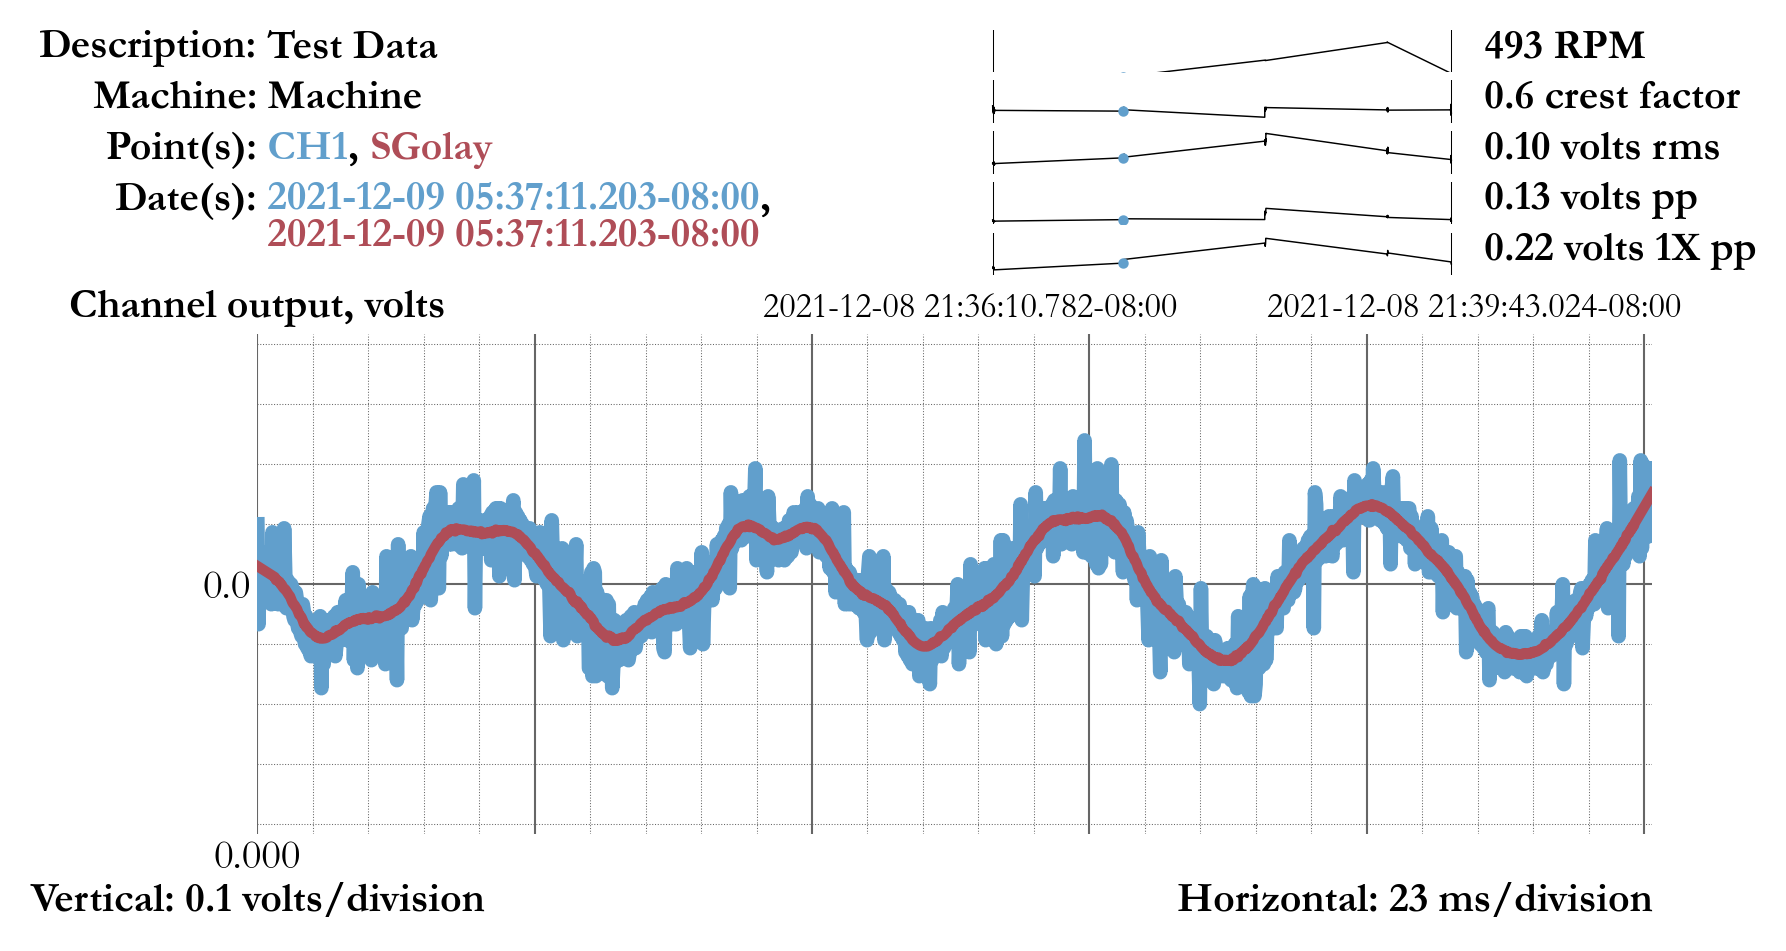

In [30]:
lst_plot_sig = class_complete.plt_sigs(b_plot_sg=True)
lst_plot_sig.savefig('TestPlot3.pdf')

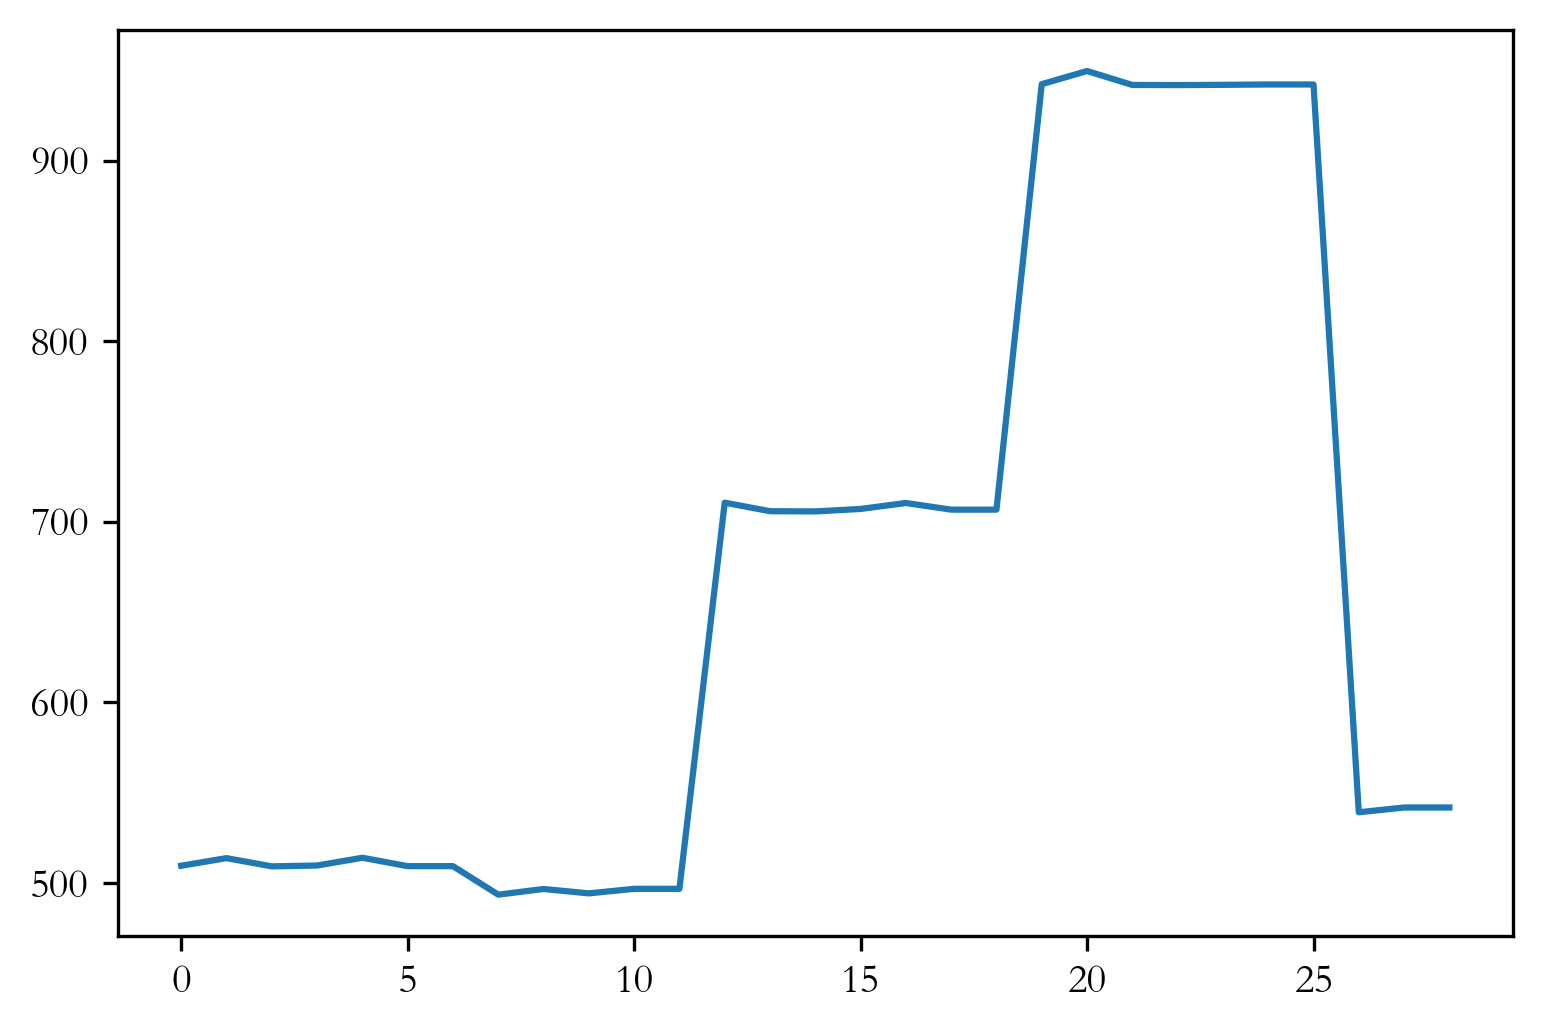

In [31]:
plt.plot(np_d_rpm_ch1)
plt.show()